In [2]:
from datetime import datetime

import numpy as np
import pandas as pd

from sklearn import preprocessing 
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn import svm
from sklearn.kernel_ridge import KernelRidge

import matplotlib.pyplot as plt

FAMA_49CRSP = 'FAMA_49CRSP.csv'

In [3]:
# https://keras.io/regularizers/
# https://keras.io/callbacks/
# https://en.wikipedia.org/wiki/Kriging
# https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# https://www.tensorflow.org/guide/summaries_and_tensorboard
# https://stackoverflow.com/questions/50978117/how-to-plot-loss-curve-in-tensorflow-without-using-tensorboard
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/normalize
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
# https://datascience.stackexchange.com/questions/989/svm-using-scikit-learn-runs-endlessly-and-never-completes-execution

# http://jack.valmadre.net/notes/2014/09/03/ridge-regression-dual/

In [4]:
def read_csv(filename):
    """
    Read in CSV file of financial ratios and returns a pandas dataframe.
    df is sorted by date in ascending order. 
    """
    df = pd.read_csv(filename)
    
    df = df.drop(labels=['pe_op_basic_Median', 'pe_op_dil_Median', 'PEG_1yrforward_Median', 'PEG_ltgforward_Median'], axis=1)
    df = df.dropna()
    df = df.sort_values(by='public_date', ascending=True)
    
    return df

In [5]:
def pct_format(col): 
    temp = [float(x[:-1]) if x is not np.nan else 0 for x in col]
    return pd.Series(temp)

In [6]:
def write_csv(filename):
    """
    Read in CSV file of financial ratios and returns a pandas dataframe.
    Drops empty columns and reformats a str col into a float col. 
    df is sorted by date in ascending order. 
    """
    df = read_csv(filename)
    
    df['divyield_Median'] = pct_format(df['divyield_Median'])
    
    df.to_csv('FAMA_49CRSP.csv')

In [8]:
write_csv('ee6d2f60cdafb550.csv')

In [7]:
def encode(df, col):
    """
    Takes in pandas dataframe and encodes df.col as numbers. 
    """
    encoder = preprocessing.LabelEncoder()
    industry_desc_encode = encoder.fit_transform(df[col])
    df[col] = industry_desc_encode
    return df 

In [8]:
def calc_rolling_avg(col, n_years):
    """
    3 years rolling percent change, averaged ie. (y1-y2 + (y3-y2)change)/2 
    """
    return col.rolling(n_years).mean()

In [9]:
def calc_year_on_year(col, p):
    """
    3year on year change as a prediction feature, raw pct change
    """
    return col.diff(periods=p)

In [10]:
def chop(col, index):
    return col.iloc[index:]

In [11]:
def discretize(series, n_bins):
    #add -1 and 1 so the bins will take on bins to be equal and set to max -1 and 1
    endpoints = pd.Series([-1,1])
    series = series.append(endpoints)

    #make a new output (bucket by percentage?)
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal',strategy = 'uniform')
    series = np.asarray(series).reshape((-1,1))

    labels_binned = discretizer.fit_transform(series)

    return labels_binned[:-2]

In [12]:
def process_data():
    """
    Reads in a CSV file and encodes text columns. 
    Removes indret_ew, indret_vw from df. 
    Returns df (X matrix) and ew_indret (Y values )
    """
    df = pd.read_csv(FAMA_49CRSP, header=0, dtype={'public_date' : str})
    df = encode(df, 'FFI49_desc')
    
    ew_indret, vw_indret = df.indret_ew, df.indret_vw 
    
    df = df.drop(labels=['indret_ew', 'indret_vw'], axis=1)
    
    rolling_avg = calc_rolling_avg(ew_indret, 3)
    year_on_year = calc_year_on_year(ew_indret, 3) 
    
    df, ew_indret, year_on_year, rolling_avg = chop(df, 3), chop(ew_indret, 3), chop(year_on_year, 3), chop(rolling_avg, 3) 
    
    ew_binned = discretize(ew_indret, 8)
    
    return df, ew_indret, ew_binned, year_on_year, rolling_avg

In [13]:
def split_data(x, y): 
    """
    Splits data into 0.64 Train, 0.16 dev, 0.2 Test
    """
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)
    x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size = 0.2, shuffle = False)
    
    return x_train, x_test, x_dev, y_dev, y_train, y_test

In [14]:
def dev(model, x_train, y_train, x_dev, y_dev):
    # also try RMSE? 
    y_train_predict = model.predict(x_train)
    train_mse = metrics.mean_squared_error(y_train, y_train_predict)
    
    y_dev_predict = model.predict(x_dev)
    mse = metrics.mean_squared_error(y_dev, y_dev_predict)
    r2 = metrics.r2_score(y_dev, y_dev_predict)
    
    print('R2: {}\tMSE: {}'.format(r2, mse))
    return y_train_predict, y_dev_predict

In [24]:
# Ordinary Least Squares: MSE 0.0064 
# ElasticNet: MSE 0.0047
# Ridge: MSE 0.0065
# Kernel Ridge Regression: MSE 0.0050
# Lasso: MSE 0.00456


def train_GDR(x_train, y_train):
    gpr = GaussianProcessRegressor()
    gpr.fit(x_train, y_train)
    return gpr

def train_LinearRegression(x_train, y_train):
    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
    return regr

def train_Ridge(alpha, x_train, y_train):
    reg = linear_model.Ridge(alpha=alpha)
    reg.fit(x_train, y_train) 
    return reg

def train_Lasso(alpha, x_train, y_train):
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(x_train, y_train)
    return clf
    
def train_ElasticNet(alpha, x_train, y_train):
    reg = linear_model.ElasticNet(alpha=alpha)
    reg.fit(x_train, y_train) 

    return reg

def train_SVR(x_train, y_train):
    """
    Takes scaled training data (does not converge otherwise) 
    """
    x_train = preprocessing.scale(x_train)
    x_dev = preprocessing.scale(x_dev)

    reg = svm.SVR(kernel='poly', gamma='auto')
    reg.fit(x_train, y_train) 

    return reg, x_dev, y_dev

def train_KRR(alpha, x_train, y_train):
    """
    Takes scaled training data (to avoid singular matrix problem? )
    """
    KRR = KernelRidge(alpha=alpha)
    KRR.fit(x_train, y_train)
    return KRR

In [19]:
def graph(x, y_real, y_pred, industry):
    x_industry = x[x['FFI49_desc'] == industry]
    y_industry = y_real[x['FFI49_desc'] == industry]
    y_pred = y_pred[x['FFI49_desc'] == industry]
    x = [datetime(year=int(x[0:4]), month=int(x[4:6]), day=int(x[6:8])) for x in x_industry['public_date']] 
    
    plt.plot(x ,y_industry, color='tab:green')
    plt.plot(x, y_pred, color='tab:red')
    plt.show()
    

In [20]:
df, ew_indret, ew_binned, year_on_year, rolling_avg = process_data()
x_train, x_test, x_dev, y_dev, y_train, y_test = split_data(df, ew_indret) 

R2: -0.0704178846774457	MSE: 0.004923484831678661


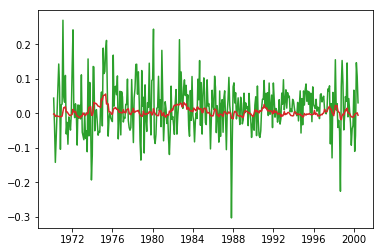

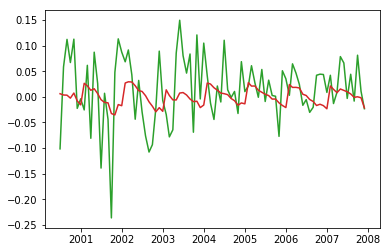

In [26]:
regr = train_LinearRegression(x_train, y_train)
lr_train_predict, lr_dev_predict = dev(KRR, scaled_x, y_train, scaled_x_dev, y_dev)

graph(x_train, y_train, KRR_train_predict, 0)
graph(x_dev, y_dev, KRR_dev_predict, 0)

/home/klchou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.
/home/klchou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by the scale function.
  


R2: -0.0704178846774457	MSE: 0.004923484831678661


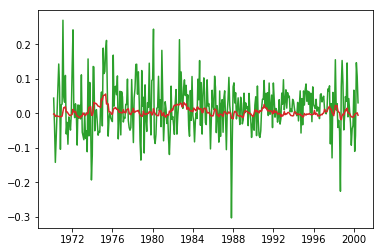

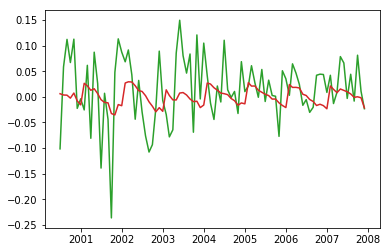

In [23]:
scaled_x = preprocessing.scale(x_train)
scaled_x_dev = preprocessing.scale(x_dev)

KRR = train_KRR(0.3, scaled_x, y_train)
KRR_train_predict, KRR_dev_predict = dev(KRR, scaled_x, y_train, scaled_x_dev, y_dev)

graph(x_train, y_train, KRR_train_predict, 0)
graph(x_dev, y_dev, KRR_dev_predict, 0)

/home/klchou/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


R2: -0.005303365128046966	MSE: 0.004623984651503595


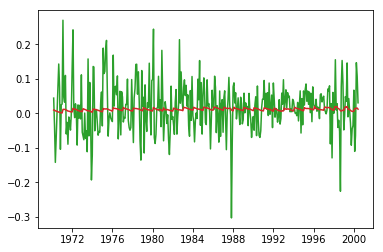

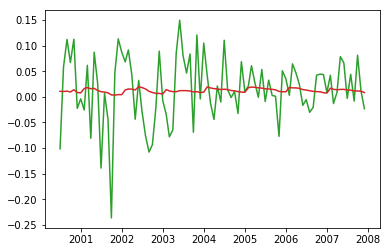

In [21]:
lasso = train_Lasso(0.01, x_train, y_train)
lasso_train_predict, lasso_dev_predict = dev(lasso,  x_train, y_train, x_dev, y_dev)

graph(x_train, y_train, lasso_train_predict, 0)
graph(x_dev, y_dev, lasso_dev_predict, 0)

/home/klchou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/home/klchou/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/klchou/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


R2: -0.04594982593092034	MSE: 0.004810941760581301


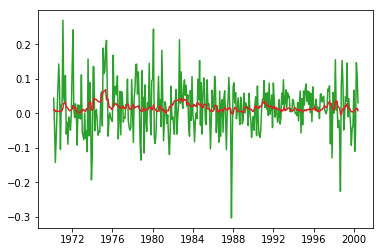

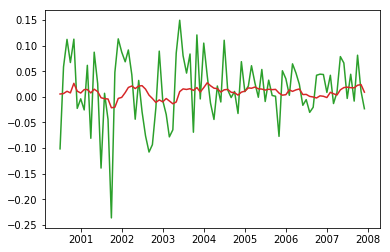

In [22]:
elastic_net = train_ElasticNet(0, x_train, y_train)
elasticnet_train_predict, elasticnet_dev_predict = dev(elastic_net,  x_train, y_train, x_dev, y_dev)

graph(x_train, y_train, elasticnet_train_predict, 0)
graph(x_dev, y_dev, elasticnet_dev_predict, 0)